### Naive Risk Budgeting Strategies between PSP and GHP

In [27]:
# used during development to releoad modules every time there is a change
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from risk_kit import Metrics, pre_processing_ind, get_ind30_nfirms,\
                    get_ind30_size, plot_ef2, fixedmix_allocator, glidepath_allocator
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.6f}'.format

m = Metrics()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's figure out how to build Allocators, portfolio that makes the PSP and GHP
in a systematic way

In [2]:
# generate rates and ZC Bond prices
rates, zc_prices = m.cir(10, 500, b=0.03, r_0=0.03)
# let's consider a 10-year bond
price_10 = m.bond_price(10, 100, 0.05, 12, rates)
rets_10 = m.bond_total_return(price_10, 100, 0.05, 12)
# let's consider a 30-year bond after 10 years
price_30 = m.bond_price(30, 100, 0.05, 12, rates)
rets_30 = m.bond_total_return(price_30, 100, 0.05, 12)

In [4]:
rets_bonds = m.bt_mix(rets_10, rets_30, allocator=fixedmix_allocator, w1=.6)
rets_bonds.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
1,0.001429,-0.037709,-0.049564,-0.031290,0.033272,-0.036172,-0.003436,0.037842,0.014303,-0.039820,...,-0.015981,-0.027405,0.003249,0.021505,0.015596,-0.027088,-0.025103,0.009861,-0.005952,-0.048879
2,0.013651,0.005737,0.083275,-0.009013,-0.014935,0.009622,0.009717,0.042955,0.025218,-0.017660,...,-0.042280,0.023023,0.019870,0.063894,0.051877,0.016924,-0.021603,-0.009209,-0.016207,-0.056571
3,0.001005,-0.036047,-0.020224,0.022661,0.037914,-0.079990,-0.032711,0.011918,-0.032728,0.002086,...,0.022781,0.006443,-0.006908,-0.015018,-0.025812,0.030509,-0.025985,0.039282,-0.016764,-0.007300
4,0.004276,0.001403,0.059476,0.039422,-0.007560,-0.004948,-0.027933,-0.042236,0.013263,0.042423,...,-0.092477,0.024644,-0.019816,0.000897,-0.059358,0.022438,0.027420,-0.018831,0.068234,0.043151
5,0.000561,0.053520,-0.004056,0.005981,-0.009102,-0.023691,0.034927,0.013654,-0.051613,-0.011418,...,0.012078,-0.039253,-0.030158,0.004213,0.025594,0.022736,0.004317,-0.001194,-0.030491,0.019036


In [5]:
# build composite return across all bonds
mean_rets_bonds = rets_bonds.mean(axis="columns")
m.summary_stats(pd.DataFrame(mean_rets_bonds))

,Ann. Return,Ann. Volatility,Skewness,Kurtosis,Corn-Fisher VaR (5%),Hist. CVar (5%),Sharpe Ratio,Max Drawdown
0,0.035870,0.003384,0.051227,3.615259,-0.001368,-0.000865,1.688565,-0.000106


In [6]:
price_eq = m.gbm(n_years=10, n_scenarios=500 , mu=0.07, sigma=0.15)
rets_eq =price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

In [7]:
# construct a portfolio PSP and GHP
rets_7030b = m.bt_mix(rets_eq, rets_bonds, allocator=fixedmix_allocator, w1=0.7)

In [8]:
# build composite return across PSP/GHP (appriximate with one time series)
mean_rets_7030b = rets_7030b.mean(axis="columns")
m.summary_stats(pd.DataFrame(mean_rets_7030b))

,Ann. Return,Ann. Volatility,Skewness,Kurtosis,Corn-Fisher VaR (5%),Hist. CVar (5%),Sharpe Ratio,Max Drawdown
0,0.059438,0.004492,0.045154,2.411831,-0.002701,-0.002332,6.377954,0.000000


The annualized return is greater with PSP/GHP than the sole GHP.
The conclusion is: 
if you have the money to buy a ZC Bond (or equivalently a mix of coupon-paying bonds
that matches the duration of the desired ZC bond (i.e. your liability) to get a funding ratio of 100%
then you are good!
Otherwise, if your funnding ratio is less then one, you have to put some money in the PSP
to increase the probability of getting the Funding Ratio as close as possible to 1.

In [11]:
# ASIDE NOTE:
# to get a more precise summary stat you have to calculate it this way:
summaries = m.summary_stats(rets_7030b)

In [12]:
summaries.head()

,Ann. Return,Ann. Volatility,Skewness,Kurtosis,Corn-Fisher VaR (5%),Hist. CVar (5%),Sharpe Ratio,Max Drawdown
0,0.058541,0.118286,0.307924,3.596302,0.047161,0.060519,0.234696,-0.228350
1,0.032145,0.111612,-0.209626,2.837318,0.051610,0.066639,0.018563,-0.228379
2,0.133244,0.095356,0.098303,2.522979,0.033732,0.043372,1.053768,-0.123952
3,0.066901,0.115826,0.371699,2.859251,0.045300,0.055228,0.309941,-0.171496
4,0.041744,0.113279,0.062336,2.347307,0.049471,0.058211,0.100760,-0.157140


In [13]:
# you get silightly different results
summaries.mean()
m.

Ann. Return             0.053949
Ann. Volatility         0.107523
Skewness                0.014977
Kurtosis                2.946384
Corn-Fisher VaR (5%)    0.045888
Hist. CVar (5%)         0.057690
Sharpe Ratio            0.218557
Max Drawdown           -0.207018
dtype: float64

In [17]:
pd.concat([
        m.terminal_stats(rets_bonds, name="FI"), # fixed income
        m.terminal_stats(rets_eq, name="Eq"), # equities
        m.terminal_stats(rets_7030b, name="70/30") # mix of PSP and LHP
        ], axis=1)

,FI,Eq,70/30
mean,1.384212,1.959991,1.777116
std,0.107460,0.978651,0.608182
p_breach,NaN,0.046000,0.016000
e_short,NaN,0.147844,0.097574
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


COMMENT: as you can see with Fixed Income porfolio
we exceed our target and we never fall below our floor (set at 80%)
with Equity only portfolio, we miss our minimum less than 5% of the cases and the expected shortfall is almost 15%. Finally with the fixed-mix portfolio. We still miss our targer in a small number of cases with an expected shortfall of roughly 10%.
We will see how we can hit our liability no matter what happens!

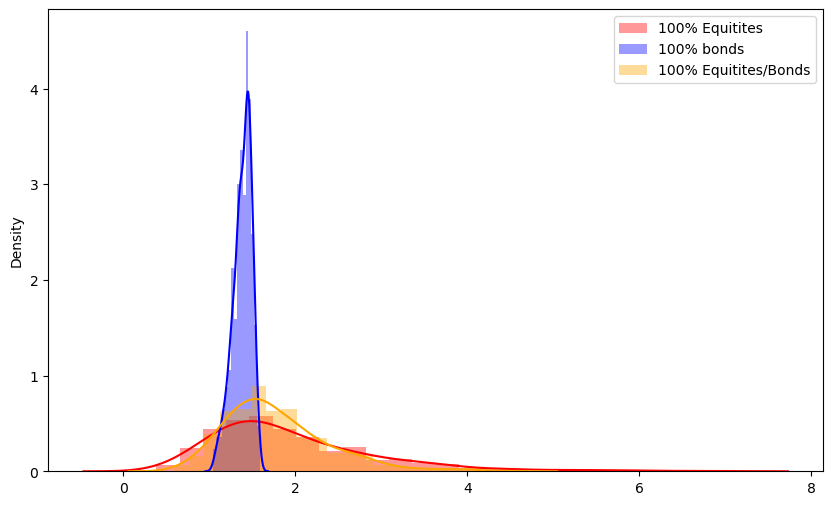

In [26]:
sns.distplot(m.terminal_values(rets_eq), color="red", label="100% Equitites")
sns.distplot(m.terminal_values(rets_bonds), color="blue", label="100% bonds")
sns.distplot(m.terminal_values(rets_7030b), color="orange", label="100% Equitites/Bonds")
plt.legend();

COMMENT: from these graphs let's explore hte following idea:
we consider risk as time and as we get close to the end of our time period we move towards bond.
this is the basic idea of a Target-Date Fund.
Let's simulatee this behaviour and see what happens.  (Glide Paths)

In [33]:
rets_g8020 = m.bt_mix(rets_eq, rets_bonds, allocator=glidepath_allocator, start_glide=0.8, end_glide=0.2)

In [35]:
pd.concat([
        m.terminal_stats(rets_bonds, name="FI"), # fixed income
        m.terminal_stats(rets_eq, name="Eq"), # equities
        m.terminal_stats(rets_7030b, name="70/30"), # mix of PSP and LHP
        m.terminal_stats(rets_g8020, name="Glide 80 to 20") # mix of PSP and LHP with Glide Paths
        ], axis=1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.384212,1.959991,1.777116,1.661710
std,0.107460,0.978651,0.608182,0.425427
p_breach,NaN,0.046000,0.016000,0.004000
e_short,NaN,0.147844,0.097574,0.017122
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


COMMENT: Glide Paths is better but still does not solv the problem (4 over 1000 cases floor is breached)